In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.quantum_info import SparsePauliOp, entanglement_of_formation, DensityMatrix

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from scipy.optimize import minimize


import numpy as np
import matplotlib.pyplot as plt


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import Estimator
from qiskit_aer.primitives import EstimatorV2 as EstimatorAer
from qiskit_aer import AerSimulator


from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2,
    SamplerV2 as Sampler,
    EstimatorOptions
)


from qiskit.visualization import plot_distribution


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer



from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint



from entanglement_measures import GHZ_entanglmenetlike_measure, Multipartite_Negativity, multipartite_entanglement

import multiprocessing as mp

In [3]:

#@jit
def initialize_LiH_vqe_chemical(intermolecular_distance= 1, mapper= JordanWignerMapper(), basis = 'sto-3g'):
    
    driver = PySCFDriver(atom=f"Li 0 0 0; H 0 0 {intermolecular_distance}", basis=basis)
    full_problem = driver.run()

    act_space_tf = ActiveSpaceTransformer(num_electrons= 2, num_spatial_orbitals= 2)

    problem = act_space_tf.transform(full_problem)

    mapper = ParityMapper(num_particles=(problem.num_alpha, problem.num_beta))

    

    pauli_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())


    #then we generate the Ansatz
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz = UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state)
    
    return ansatz, pauli_hamiltonian, problem


#@jit
def vqe_chemical_ansatz(estimator, ansatz, problem, mapper=JordanWignerMapper(), optimizer= SLSQP()):
    vqe = VQE(estimator= estimator,
              ansatz= ansatz,
              optimizer= optimizer)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem

    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)

    result = solver.solve(problem)

    gs_energy = result.total_energies[0]
    utilized_ansatz = result.groundstate[0]
    optimized_parameters = result.groundstate[1]

    optimal_ansatz = utilized_ansatz.assign_parameters(optimized_parameters)

    return gs_energy, optimal_ansatz



#@jit
def run_calculation_for_gs(swept_interval, estimator):

    with mp.Pool() as pool:
            

        distances = swept_interval

        num_calc = len( swept_interval )

        entanglement_list_max = np.zeros(num_calc)
        entanglement_list_total = np.zeros(num_calc)

        negativity_list_max = np.zeros(num_calc)
        negativity_list_total = np.zeros(num_calc)

        ghz_measure_list = np.zeros(num_calc)

        energiesH2_list = np.zeros(num_calc)


        
        for i, d in enumerate(swept_interval):

            ansatz_h2, pauli_ham_h2, prob = initialize_LiH_vqe_chemical(intermolecular_distance= d)

            gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatz(estimator=estimator,
                                                                ansatz= ansatz_h2,
                                                                problem= prob)
            

            r = DensityMatrix(optimal_ansatz_d)

        

            energiesH2_list[i] = gs_energy_d

            entanglement_list_max[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'max' )
            entanglement_list_total[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'total')
            
            
            negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
            negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
            
            ghz_measure_list[i] = GHZ_entanglmenetlike_measure(optimal_ansatz_d)

        return energiesH2_list, entanglement_list_max, entanglement_list_total, negativity_list_max, negativity_list_total, ghz_measure_list

In [4]:
distances = np.arange(0.75, 4.25, 0.1)

estimator = Estimator()


energies_LiH, entgmax_LiH, entgtotal_LiH, negmax_LiH, negtotal_LiH, ghzmeasure_LiH = run_calculation_for_gs(swept_interval= distances, estimator= estimator)

/tmp/ipykernel_12198/3879869033.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
/tmp/ipykernel_12198/3879869033.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')


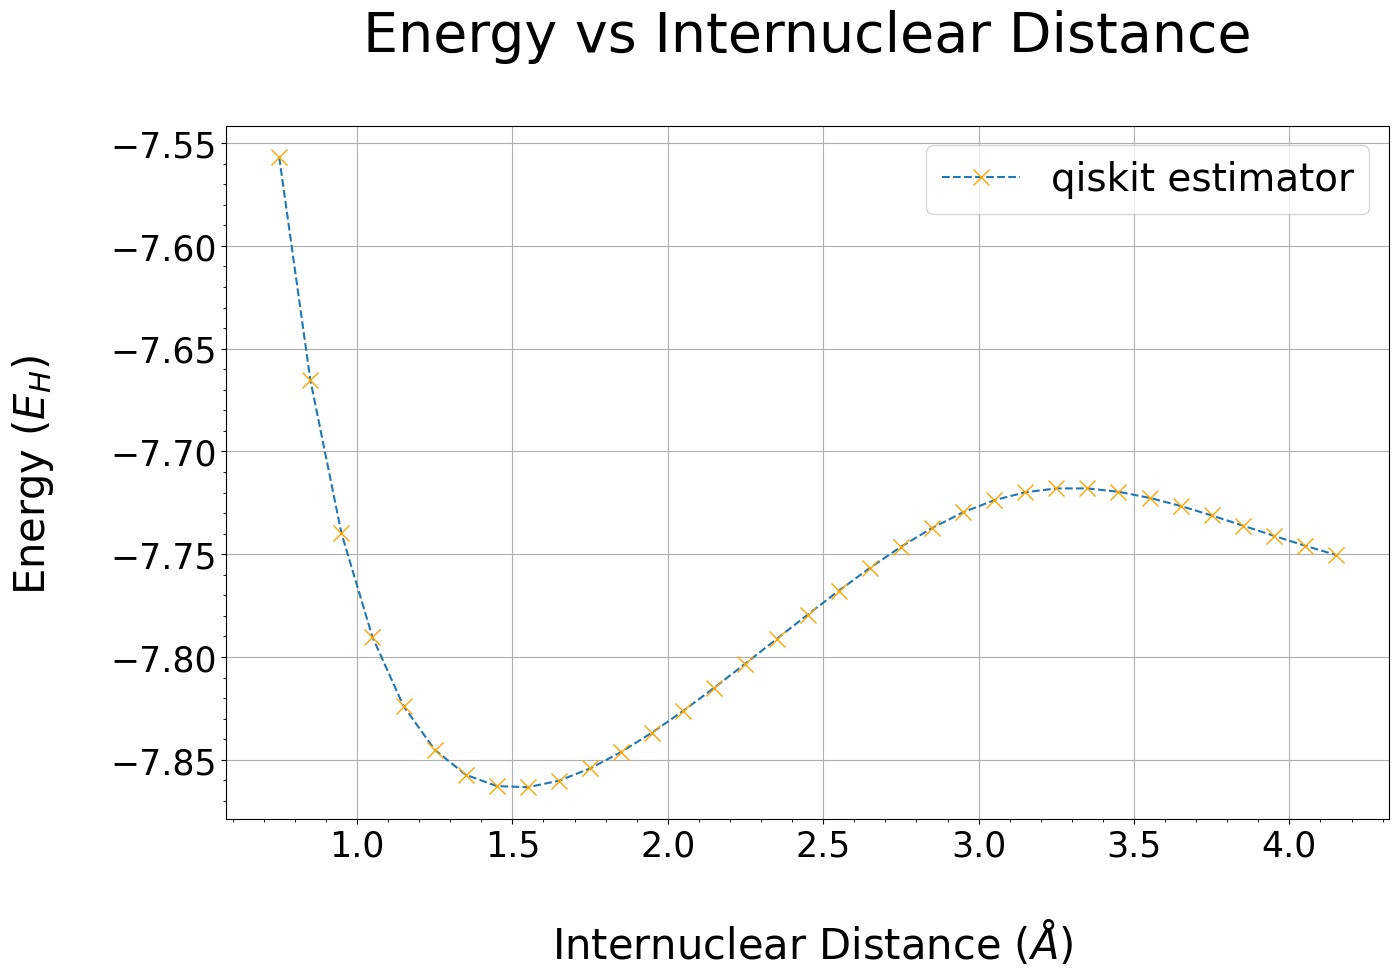

In [5]:
# Plotting the data

plt.figure(figsize=(15, 9))
plt.errorbar(distances, energies_LiH, marker='x', linestyle='--', label= 'qiskit estimator', markeredgecolor= 'orange', markerfacecolor= 'orange', markersize= 12 )
plt.xlabel('\n Internuclear Distance ($\AA$) ', fontsize= 30 )
plt.ylabel('Energy ($E_H$) \n', fontsize= 30)
plt.title('Energy vs Internuclear Distance\n', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

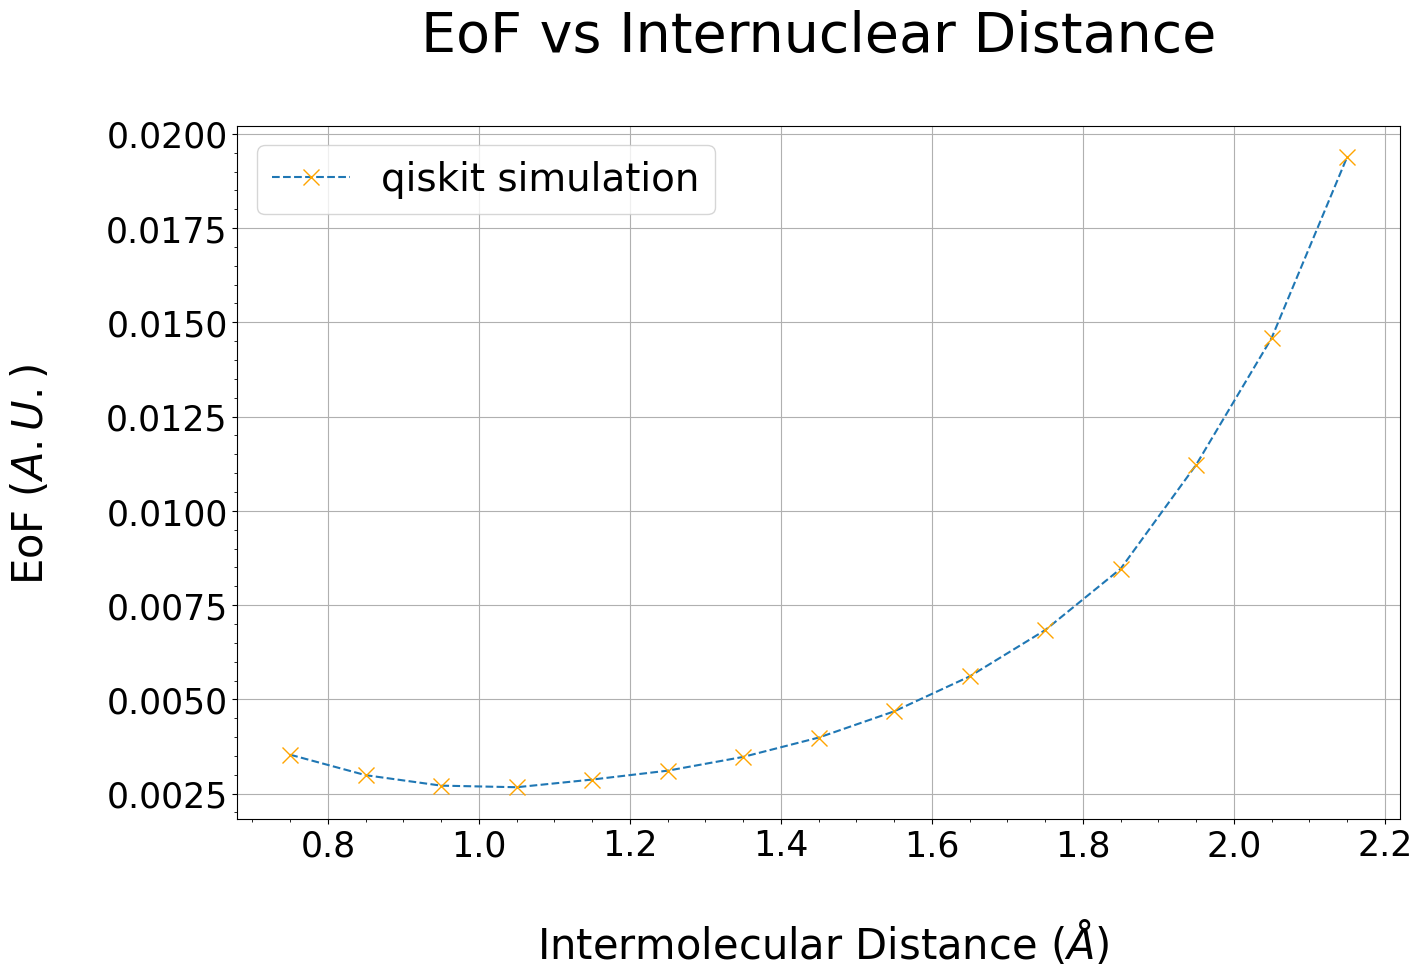

In [6]:
# Plotting the data

plt.figure(figsize=(15, 9))
plt.plot(distances[:15], entgmax_LiH[:15], marker='x', linestyle='--', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 12)
plt.xlabel('\n Intermolecular Distance ($\AA$) ', fontsize= 30 )
plt.ylabel('EoF ($A.U.$) \n', fontsize= 30)
plt.title('EoF vs Internuclear Distance\n', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

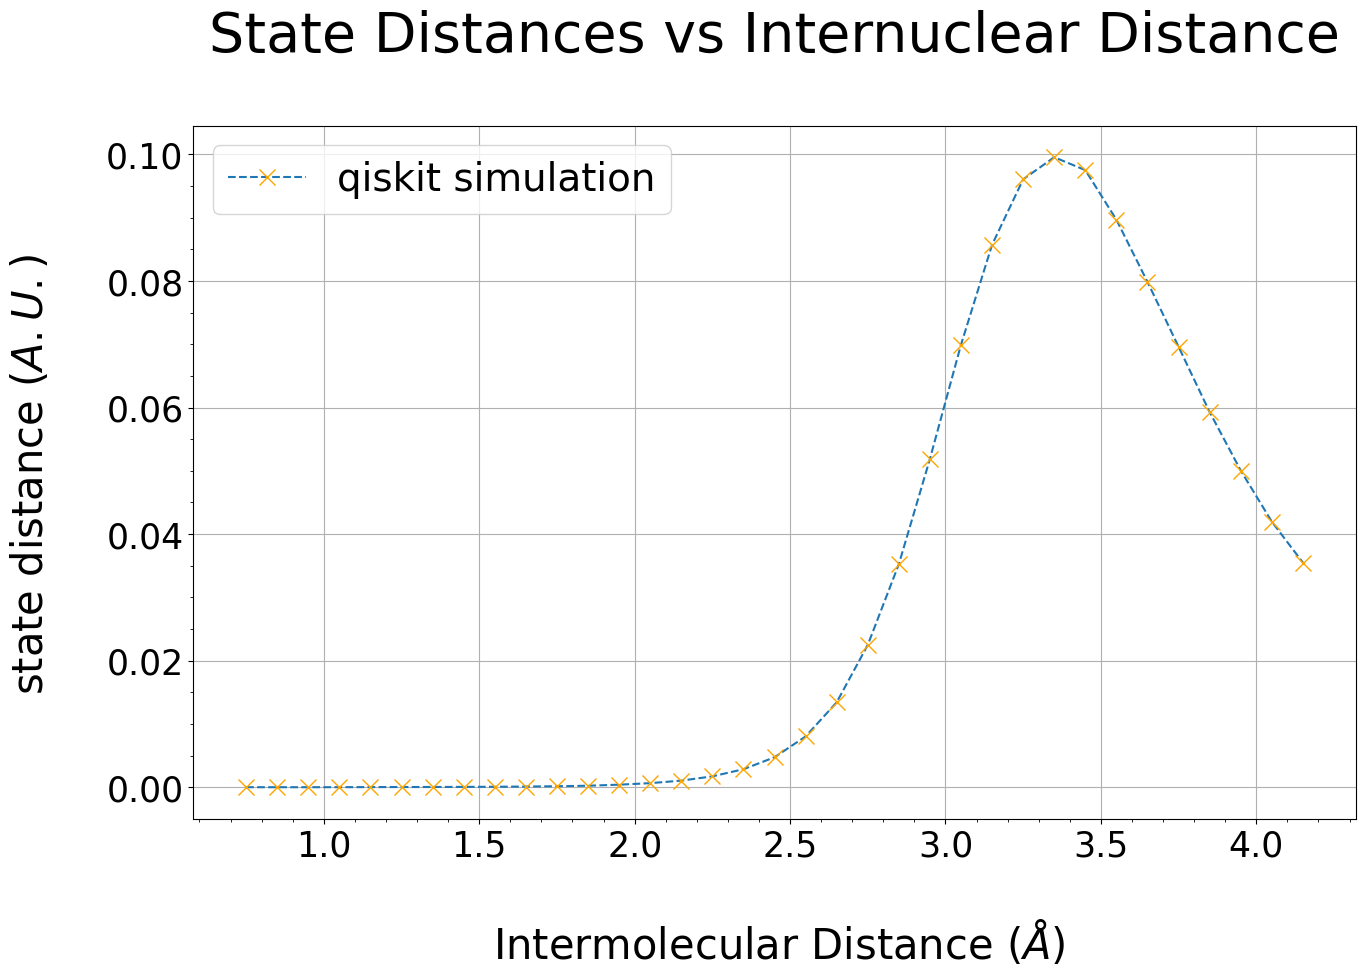

In [7]:
# Plotting the data

plt.figure(figsize=(15, 9))
plt.plot(distances, ghzmeasure_LiH, marker='x', linestyle='--', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 12)
plt.xlabel('\n Intermolecular Distance ($\AA$) ', fontsize= 30 )
plt.ylabel('state distance ($A.U.$) \n', fontsize= 30)
plt.title('State Distances vs Internuclear Distance\n', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

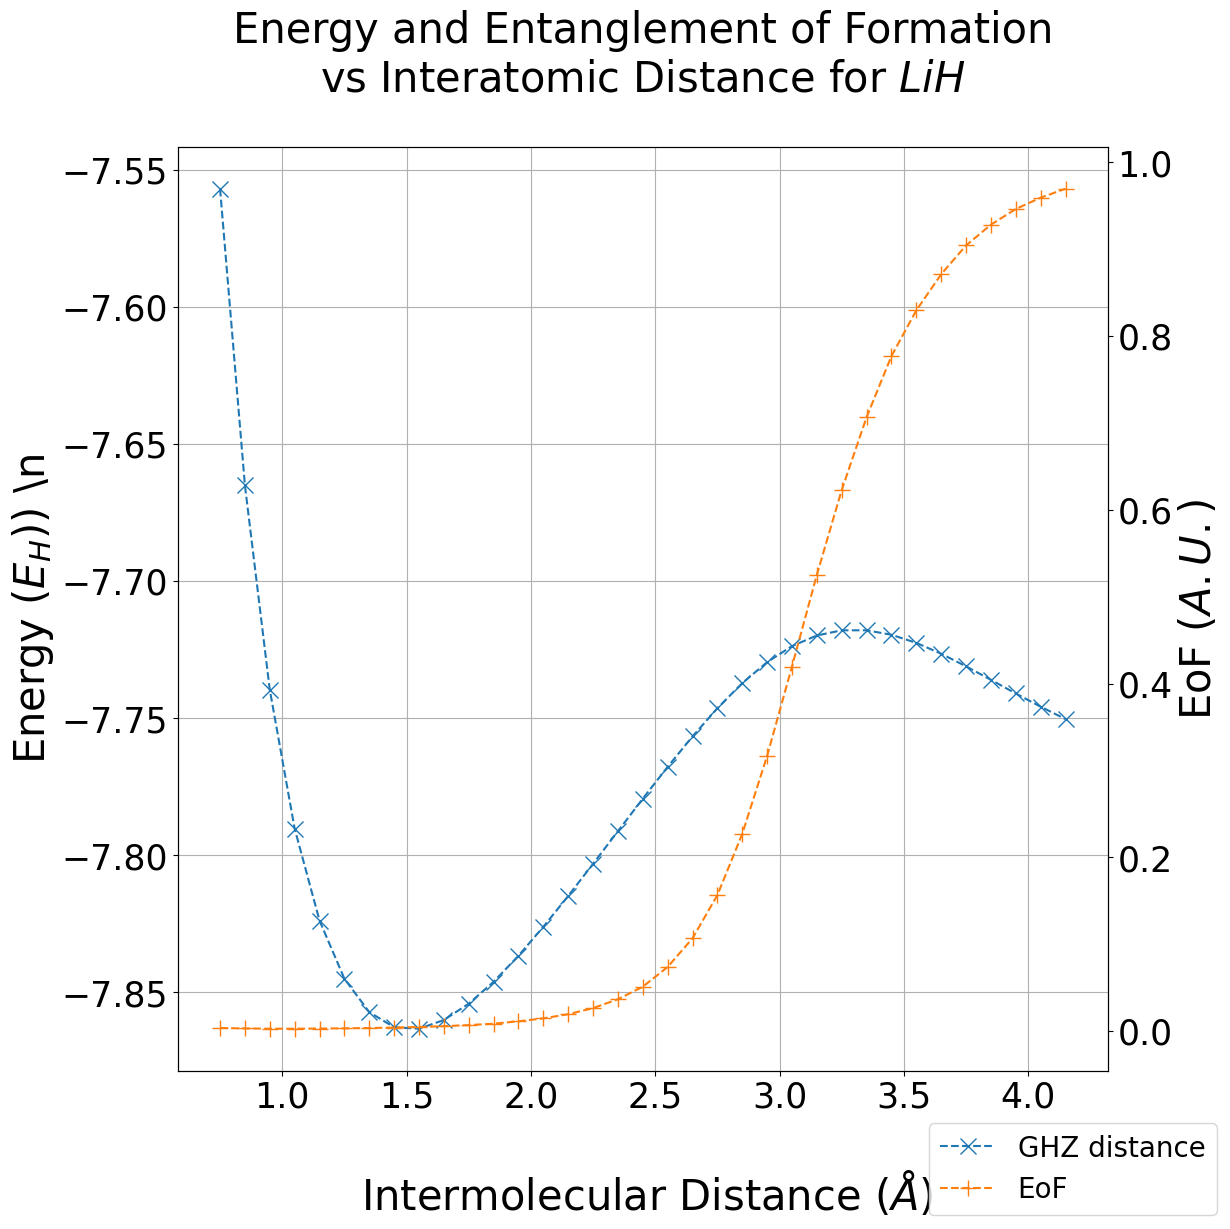

In [8]:
# Plotting the data

fig, ax1 = plt.subplots(figsize=(12, 12))


ax1.plot(distances, energies_LiH, marker='x', linestyle='--', label= 'GHZ distance', markersize= 12)

ax1.set_xlabel('\n Intermolecular Distance ($\AA$) ', fontsize= 30 )
ax1.set_ylabel(r'Energy ($E_H$)) \n', fontsize= 30)
ax1.set_title(r'Energy and Entanglement of Formation' + '\n' + r'vs Interatomic Distance for $LiH$', fontsize=30, pad=40)


ax1.grid(True)
ax1.tick_params(axis='y')
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

ax2 = ax1.twinx()

ax2.plot(distances, entgtotal_LiH, marker='+', linestyle='--',label= 'EoF' , markersize= 12, color= 'tab:orange')
ax2.set_ylabel('EoF ($A.U.$)',  fontsize= 30)
ax2.tick_params(axis= 'y')


fig.legend( loc='lower right' ,fontsize= 20)
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here


plt.savefig('energy_entanglement_lih.svg', format='svg', bbox_inches='tight')


#fig.tight_layout()
plt.show()



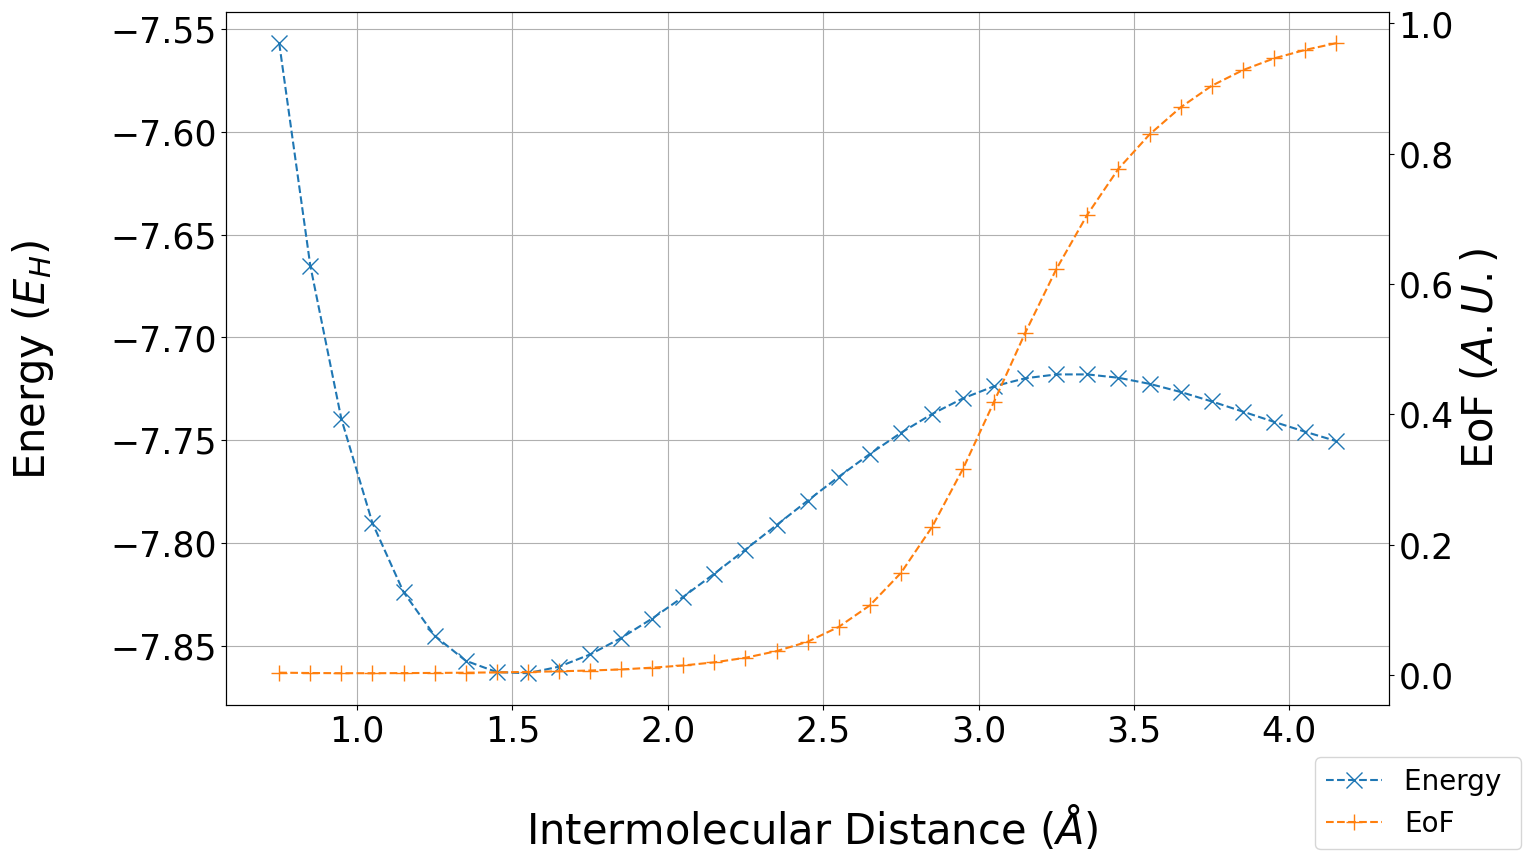

In [9]:
# Plotting the data

fig, ax1 = plt.subplots(figsize=(15, 9))


ax1.plot(distances, energies_LiH, marker='x', linestyle='--', label= 'Energy ', markersize= 12)

ax1.set_xlabel('\n Intermolecular Distance ($\AA$) ', fontsize= 30 )
ax1.set_ylabel('Energy ($E_H$) \n', fontsize= 30)
#ax1.set_title('State Distances vs Internuclear Distance\n', fontsize= 40)
ax1.grid(True)
ax1.tick_params(axis='y')
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

ax2 = ax1.twinx()

ax2.plot(distances, entgtotal_LiH, marker='+', linestyle='--',label= 'EoF' , markersize= 12, color= 'tab:orange')
ax2.set_ylabel('EoF ($A.U.$)',  fontsize= 30)
ax2.tick_params(axis= 'y')


fig.legend( loc='lower right' ,fontsize= 20)
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here


#fig.tight_layout()
plt.show()


In [10]:
def final_stats(distances_list, energies_list):
    gs_energy = np.min(energies_list)

    gs_ener_indx = np.where(energies_list == gs_energy)[0][0]

    minimal_distance = distances_list[gs_ener_indx]

    print(f'Ground State Energy: {gs_energy} Hartree \n Distance of Equilibrium: {minimal_distance} Armstrongs')

In [11]:
final_stats(distances, energies_LiH)

Ground State Energy: -7.863316778812375 Hartree 
 Distance of Equilibrium: 1.5499999999999998 Armstrongs


In [12]:
(np.abs(-7.863579810498766 + 8.070548) / 8.070548 ) * 100

np.float64(2.5644874363083408)

In [13]:
from qiskit_aer.primitives import Estimator as AerEstimator

distances = np.arange(0.5, 4.25, 0.1)

noiseless_estimator = AerEstimator(shots= 1024)

energies_LiH, entgmax_LiH, entgtotal_LiH, negmax_LiH, negtotal_LiH, ghzmeasure_LiH = run_calculation_for_gs(swept_interval= distances, estimator= estimator)

TypeError: Estimator.__init__() got an unexpected keyword argument 'shots'

In [25]:

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_aer.primitives import Estimator as AerEstimator


from qiskit.providers.fake_provider import GenericBackendV2

device = GenericBackendV2(num_qubits= 127)

noisy_estimator = AerEstimator(backend_options= {'method' : 'density_matrix', 'device' : 'GPU'},
                               run_options= {'shots' : 1024})

#@jit
def initialize_LiH_vqe_chemicalV2(intermolecular_distance= 1, ansatz = 'EfficientSU2'
                                  ,mapper= JordanWignerMapper(), basis = 'sto-3g'):
    
    driver = PySCFDriver(atom=f"Li 0 0 0; H 0 0 {intermolecular_distance}", basis=basis)
    full_problem = driver.run()

    act_space_tf = ActiveSpaceTransformer(num_electrons= 2, num_spatial_orbitals= 2)

    problem = act_space_tf.transform(full_problem)

    mapper = ParityMapper(num_particles=(problem.num_alpha, problem.num_beta))

    pauli_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())


    #then we generate the Ansatz
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz_dict = { 'UCCSD' : UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state),
               'EfficientSU2' : EfficientSU2(num_qubits= pauli_hamiltonian.num_qubits,
                                             entanglement= 'pairwise',
                                             skip_unentangled_qubits= True,
                                             reps= 3,
                                             insert_barriers= True
                                             )}
    
    
    # ansatz is de circuit parametrized by the vet \theta
    #pauli hamiltonian is the SparsePauliOp from the problem,
    #after being mapped with a certain transformation.
    #probelm is just raw qikist-nature thing

    return ansatz_dict[ansatz], pauli_hamiltonian, problem #returns the Ansatz circuit, e



#@jit
def vqe_chemical_ansatzV2(estimator, ansatz, sparse_problem, problem, mapper=JordanWignerMapper(), optimizer= SLSQP()):
    
    counts = []
    values = []
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(noisy_estimator, ansatz, optimizer= SPSA(maxiter=500), callback= store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator= sparse_problem)

    gs_energy = result.eigenvalue.real
    optimal_ansatz_circuit = result.optimal_circuit.assign_parameters(result.optimal_parameters)

    return gs_energy, optimal_ansatz_circuit






    numpy_solver = NumPyMinimumEigensolver()
    result = numpy_solver.compute_minimum_eigenvalue(operator= sparse_problem)
    ref_value = result.eigenvalue.real

    vqe = VQE(estimator= estimator,
              ansatz= ansatz,
              optimizer= optimizer)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))
    
    #only works if UCCSD ??
    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem

    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)

    result = solver.solve(problem)

    gs_energy = result.total_energies[0]
    utilized_ansatz = result.groundstate[0]
    optimized_parameters = result.groundstate[1]

    optimal_ansatz = utilized_ansatz.assign_parameters(optimized_parameters)

    return gs_energy, optimal_ansatz, ref_value




def run_calculation_for_gsV2(swept_interval, estimator):

    with mp.Pool() as pool:


        num_calc = len( swept_interval )

        entanglement_list_max = np.zeros(num_calc)
        entanglement_list_total = np.zeros(num_calc)

        negativity_list_max = np.zeros(num_calc)
        negativity_list_total = np.zeros(num_calc)

        ghz_measure_list = np.zeros(num_calc)

        energiesH2_list = np.zeros(num_calc)
        energiesH2_list_classic = np.zeros(num_calc)



        
        for i, d in enumerate(swept_interval):

            abstrac_ansatz_h2, pauli_abstrac_ham_h2, prob = initialize_LiH_vqe_chemicalV2(intermolecular_distance= d)


            
            gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatzV2(estimator= estimator,
                                                                ansatz= abstrac_ansatz_h2,
                                                                problem= prob,
                                                                sparse_problem= pauli_abstrac_ham_h2)
            



            r = DensityMatrix(optimal_ansatz_d)


            energiesH2_list[i] = gs_energy_d
            #energiesH2_list_classic[i] = ref_value

            entanglement_list_max[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'max' )
            entanglement_list_total[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'total')
            
            
            negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
            negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
            
            ghz_measure_list[i] = GHZ_entanglmenetlike_measure(optimal_ansatz_d)

        return energiesH2_list, entanglement_list_max, entanglement_list_total, negativity_list_max, negativity_list_total, ghz_measure_list


In [26]:
from qiskit_aer.primitives import Estimator as AerEstimator

from qiskit.providers.fake_provider import GenericBackendV2

device = GenericBackendV2(num_qubits= 127)

noisy_estimator = AerEstimator(backend_options= {'method' : 'density_matrix', 'device' : 'GPU'},
                               run_options= {'shots' : 5000})

distances = np.arange(0.75, 4.25, 0.1)


energies_LiH_pt2, entgmax_LiH_pt2, entgtotal_LiH_pt2, negmax_LiH_pt2, negtotal_LiH_pt2, ghzmeasure_LiH_pt2 = run_calculation_for_gsV2(swept_interval= distances, estimator= noisy_estimator)

/tmp/ipykernel_34922/1248719242.py:154: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
/tmp/ipykernel_34922/1248719242.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
/tmp/ipykernel_34922/1248719242.py:154: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
/tmp/ipykernel_34922/1248719242.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
/tmp/ipykernel_34922/1248719242.py:154: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_max[i] = Multipartite_Negativity(ci

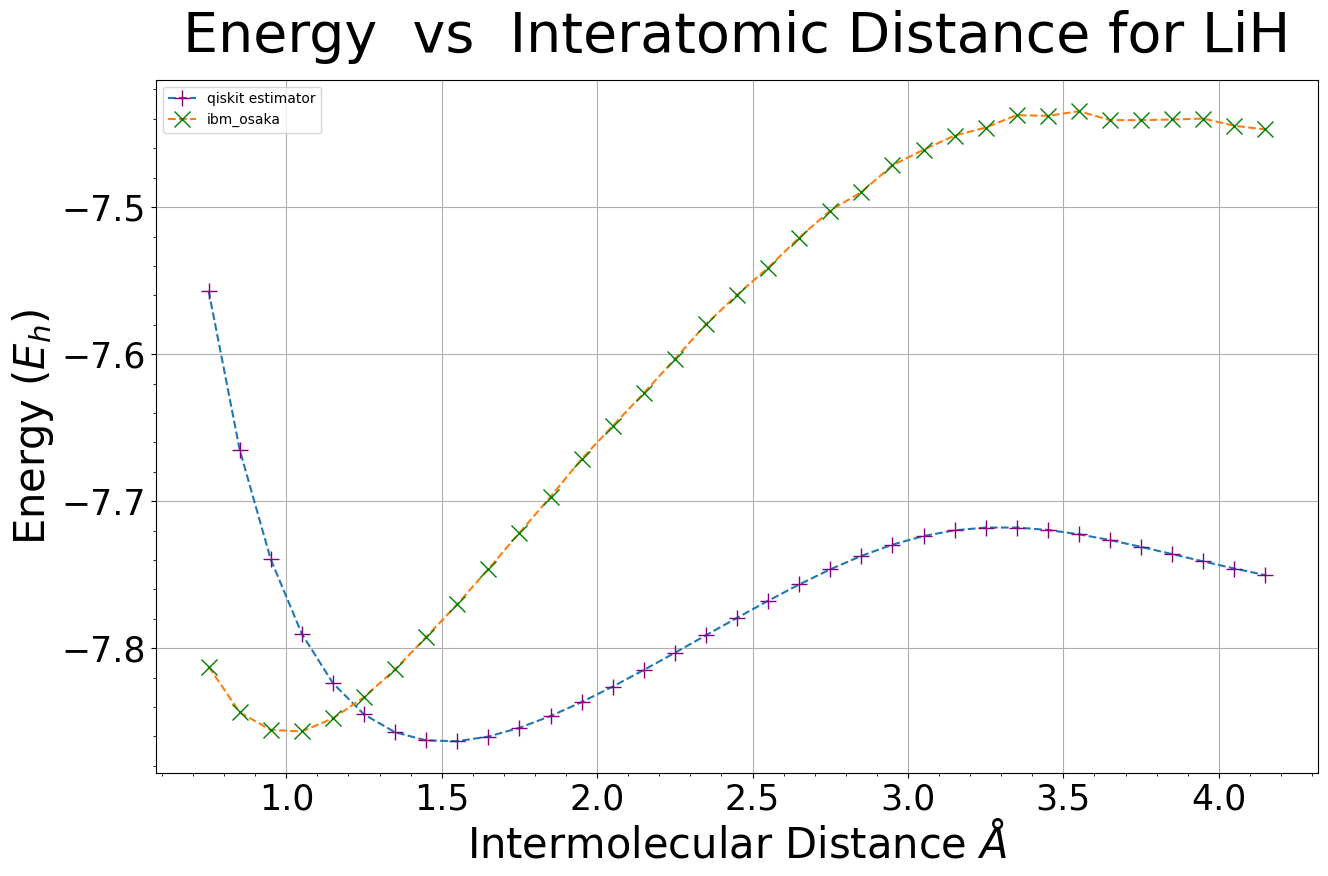

In [33]:
# Plotting the data

plt.figure(figsize=(15, 9))


plt.plot(distances, energies_LiH, marker='+', linestyle='--', label= 'qiskit estimator', markeredgecolor= 'purple', markerfacecolor= 'purple', markersize= 12)
plt.plot(distances, energies_LiH_pt2 -6.7, marker='x', linestyle='--', label= 'ibm_osaka', markeredgecolor= 'green', markerfacecolor= 'green' , markersize= 12)

#plt.plot(distances, energiesLiH_pt2_ref, marker='o', linestyle='--', label= 'reference', markeredgecolor= 'black', markerfacecolor= 'black' , markersize= 4)


plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
plt.ylabel(r'Energy ($E_h$)', fontsize= 30)
plt.title(r'Energy  vs  Interatomic Distance for LiH', fontsize= 40, pad= 20)
plt.grid(True)
plt.legend(fontsize= 10)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

In [21]:
distances = np.arange(0.75, 4.25, 0.1)


noiseless_estimator = AerEstimator()

energies_LiH_pt2, energiesLiH_pt2_ref ,entgmax_LiH_pt2, entgtotal_LiH_pt2, negmax_LiH_pt2, negtotal_LiH_pt2, ghzmeasure_LiH_pt2 = run_calculation_for_gsV2(swept_interval= distances, estimator= noiseless_estimator)

/tmp/ipykernel_6668/2983572049.py:154: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
/tmp/ipykernel_6668/2983572049.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
/tmp/ipykernel_6668/2983572049.py:154: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
/tmp/ipykernel_6668/2983572049.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
/tmp/ipykernel_6668/2983572049.py:154: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_max[i] = Multipartite_Negativity(circuit

ValueError: not enough values to unpack (expected 7, got 6)

In [29]:
from qiskit_aer.primitives import Estimator as AerEstimator

distances = np.arange(1, 2.5, 0.01)

noiseless_estimator = Estimator()

energies_LiH, entgmax_LiH, entgtotal_LiH, negmax_LiH, negtotal_LiH, ghzmeasure_LiH = run_calculation_for_gs(swept_interval= distances, estimator= estimator)

/tmp/ipykernel_2586/3879869033.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
/tmp/ipykernel_2586/3879869033.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')


In [24]:
final_stats(distances, energies_LiH)

Ground State Energy: -7.863607846944036 Hartree 
 Distance of Equilibrium: 1.5100000000000005 Armstrongs


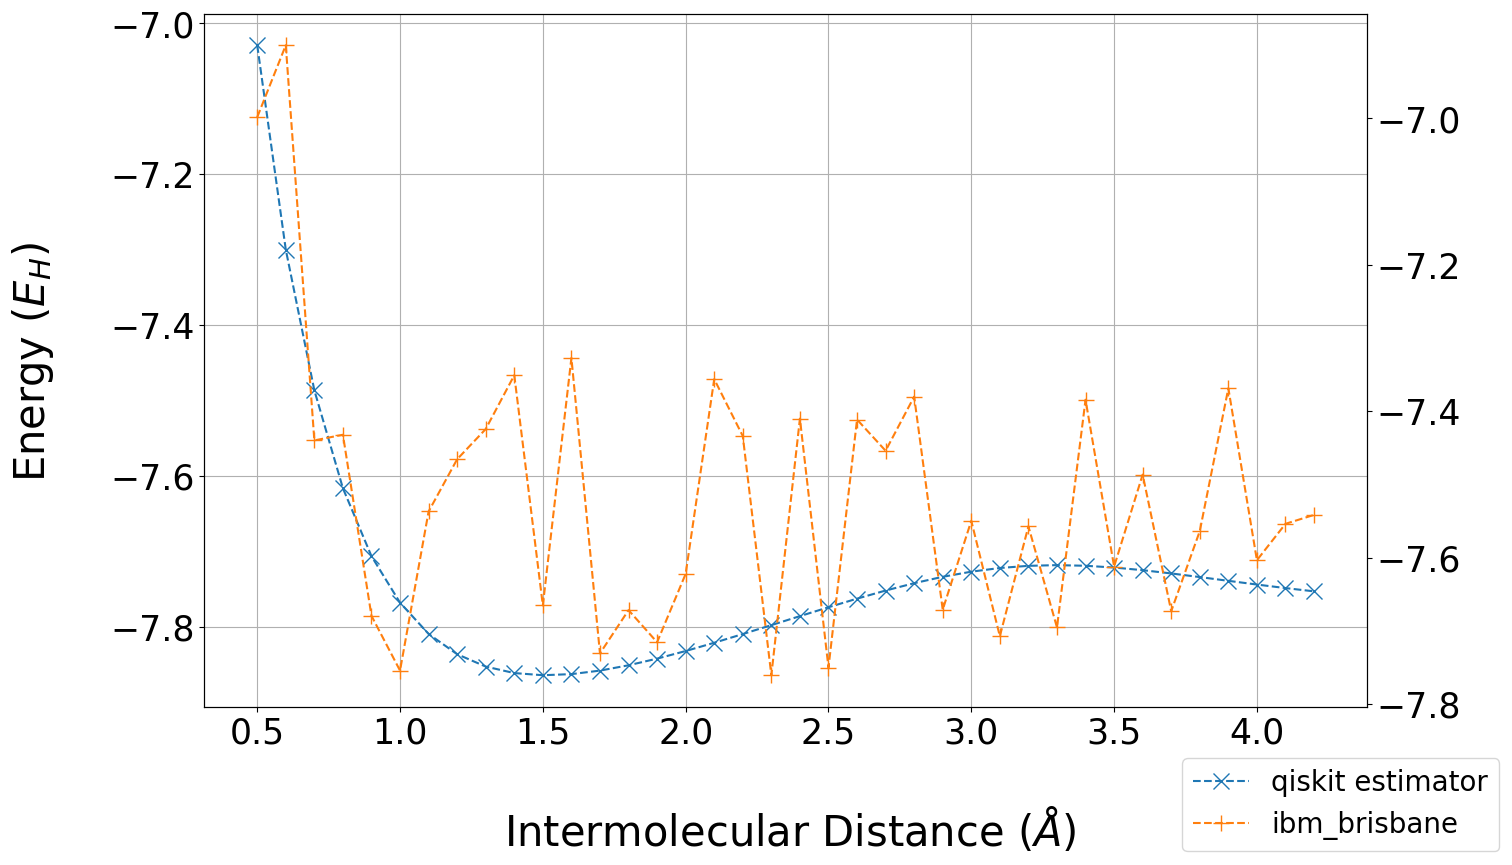

In [120]:
# Plotting the data

fig, ax1 = plt.subplots(figsize=(15, 9))


ax1.plot(distances, energies_LiH, marker='x', linestyle='--', label= 'qiskit estimator', markersize= 12)

ax1.set_xlabel('\n Intermolecular Distance ($\AA$) ', fontsize= 30 )
ax1.set_ylabel('Energy ($E_H$) \n', fontsize= 30)
#ax1.set_title('State Distances vs Internuclear Distance\n', fontsize= 40)
ax1.grid(True)
ax1.tick_params(axis='y')
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

ax2 = ax1.twinx()

ax2.plot(distances, energies_LiH_pt2, marker='+', linestyle='--',label= 'ibm_brisbane' , markersize= 12, color= 'tab:orange')
ax1.set_ylabel('Energy ($E_H$) \n', fontsize= 30)
ax2.tick_params(axis= 'y')


fig.legend( loc='lower right' ,fontsize= 20)
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here


#fig.tight_layout()
plt.show()


In [26]:

distances = np.arange(1.49, 1.6, 0.001)

noiseless_estimator = Estimator()

energies_LiH, entgmax_LiH, entgtotal_LiH, negmax_LiH, negtotal_LiH, ghzmeasure_LiH = run_calculation_for_gs(swept_interval= distances, estimator= estimator)

/tmp/ipykernel_2586/3879869033.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
/tmp/ipykernel_2586/3879869033.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')


In [27]:
final_stats(distances, energies_LiH)

Ground State Energy: -7.863608436581942 Hartree 
 Distance of Equilibrium: 1.5119999999999976 Armstrongs


# Let's run this in `ibm_brisbane`

In [41]:

import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator


from qiskit_ibm_runtime import QiskitRuntimeService, Session



def initialize_LiH_problem_ibm(intermolecular_distance= 1, basis = 'sto-3g'):
    
    driver = PySCFDriver(atom=f"Li 0 0 0; H 0 0 {intermolecular_distance}", basis=basis)
    full_problem = driver.run()

    act_space_tf = ActiveSpaceTransformer(num_electrons= 2, num_spatial_orbitals= 2)

    problem = act_space_tf.transform(full_problem)

    mapper = ParityMapper(num_particles=(problem.num_alpha, problem.num_beta))

    

    pauli_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())

    ansatz = EfficientSU2(num_qubits= pauli_hamiltonian.num_qubits,
                                             entanglement= 'pairwise',
                                             skip_unentangled_qubits= True,
                                             reps= 3,
                                             insert_barriers= True
                                             )
    
    
    # ansatz is de circuit parametrized by the vet \theta
    #pauli hamiltonian is the SparsePauliOp from the problem,
    #after being mapped with a certain transformation.
    #probelm is just raw qikist-nature thing

    return ansatz, pauli_hamiltonian


def cost_func(params, ansatz, hamiltonian, estimator, cost_history_dict):

    """Return cost function for optimization

    Parameters:
        params (ndarray): Array of ansatz parameters
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        estimator (EstimatorV2): Statevector estimator primitive instance
        pm (PassManager): Pass manager
        callback_dict (dict): Dictionary to store callback information

    Returns:
        float: Cost function estimate
    """

    #ansatz + initial state ready to run over a Hamiltonian and being optimized


    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]



    cost_history_dict['iters'] += 1
    cost_history_dict['prev_vector'] = params
    cost_history_dict['cost_value'] = 0
    
    return energy



def run_calculation_for_gsV2_ibm_brisbane(swept_interval):

    #change this
    service = QiskitRuntimeService()
    backend = service.backend('ibm_brisbane')
    ###

    pm = generate_preset_pass_manager(optimization_level=2, backend=backend)


    isa_ansatz_list = []
    isa_hamilt_list = []

    for d in swept_interval:
        
        abs_ansatz, Hamil_obs = initialize_LiH_problem_ibm(intermolecular_distance= d)
    
        # Get ISA circuits
        isa_ansatz = pm.run(abs_ansatz)
        isa_hamiltonian = Hamil_obs.apply_layout(isa_ansatz.layout)
        
        isa_ansatz_list.append(isa_ansatz)
        isa_hamilt_list.append(isa_hamiltonian)

    results = {}

    with Session(backend= backend) as session:
        estimator= Estimator(session= session)
        estimator.options.default_shots= 1024

        for index, d in enumerate(swept_interval):

            isa_ansatz = isa_ansatz_list[index]

            cost_history_dict = {'iters' : 0,
                            'prev_vector' : None,
                            'cost_value' : 0}

            init_point = np.random.random(isa_ansatz.num_parameters)

            res = minimize(
                cost_func,
                init_point,
                args=(isa_ansatz_list[index], isa_hamilt_list[index], estimator, cost_history_dict),
                method= 'cobyla'
            )
        
            results[f'{d}'] = res

        return results


In [ ]:






    num_calc = len( swept_interval )

    entanglement_list_max = np.zeros(num_calc)
    entanglement_list_total = np.zeros(num_calc)

    negativity_list_max = np.zeros(num_calc)
    negativity_list_total = np.zeros(num_calc)

    ghz_measure_list = np.zeros(num_calc)

    energiesH2_list = np.zeros(num_calc)
    energiesH2_list_classic = np.zeros(num_calc)



    
    for i, d in enumerate(swept_interval):

        abstrac_ansatz_h2, pauli_abstrac_ham_h2, prob = initialize_LiH_vqe_chemicalV2(intermolecular_distance= d)


        
        gs_energy_d, optimal_ansatz_d, ref_value = vqe_chemical_ansatzV2(estimator= estimator,
                                                            ansatz= abstrac_ansatz_h2,
                                                            problem= prob,
                                                            sparse_problem= pauli_abstrac_ham_h2)
        

        r = DensityMatrix(optimal_ansatz_d)


        energiesH2_list[i] = gs_energy_d
        energiesH2_list_classic[i] = ref_value

        entanglement_list_max[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'max' )
        entanglement_list_total[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'total')
        
        
        negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
        negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
        
        ghz_measure_list[i] = GHZ_entanglmenetlike_measure(optimal_ansatz_d)

    return energiesH2_list, energiesH2_list_classic, entanglement_list_max, entanglement_list_total, negativity_list_max, negativity_list_total, ghz_measure_list


In [42]:
distances = np.arange(0.5, 3.25, 0.25)

ibm_brisbane_result = run_calculation_for_gsV2_ibm_brisbane(distances)

/tmp/ipykernel_2586/3184883724.py:105: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator= Estimator(session= session)
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

/tmp/ipykernel_2586/1745944194.py:62: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)


IBMInputValueError: 'The instruction EfficientSU2 on qubits (0, 1, 2, 3) is not supported by the target system. Circuits that do not match the target hardware definition are no longer supported after March 4, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.'